# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

### **Objetivos**
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente LunarLander-v2 de Gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

## **1. Inicialización del ambiente**

#### **1.1 Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


#### **1.2 Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

#### **1.3 Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [144]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

## **2. Programando un agente que aprende**

A continuación implementamos el agente:

In [154]:
class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, initial_epsilon, final_epsilon, decay_factor) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.recompensa_maxima = -np.inf
        self.decay_factor = decay_factor
        self.threshold = 0
            
    def estado_discretizado_a_indice(self, estado_discretizado):
        return estado_discretizado[0] * 12800000 + estado_discretizado[1] * 640000 + estado_discretizado[2] * 32000 + \
           estado_discretizado[3] * 1600 + estado_discretizado[4] * 80 + estado_discretizado[5] * 4 + \
           estado_discretizado[6] * 2 + estado_discretizado[7]
           
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        estado_discretizado = discretize_state(estado, bins)
        row = self.estado_discretizado_a_indice(estado_discretizado)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.estado_discretizado_a_indice(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.estado_discretizado_a_indice(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.threshold: 
            self.epsilon = max(self.final_epsilon, self.epsilon*self.decay_factor)
            self.threshold += 1
        

#### **2.1 Diseño**

Nuestra implementación del agente sigue un flujo iterativo donde, en cada episodio, el agente interactúa continuamente con el entorno para aprender y mejorar su comportamiento. El proceso comienza cuando el agente recibe un estado inicial y, utilizando la función `elegir_accion`, selecciona una acción basándose en la política **epsilon-greedy**, que equilibra la exploración de nuevas acciones y la explotación de las acciones ya experimentadas. Tras ejecutar la acción, el agente recibe una recompensa y un nuevo estado, lo que desencadena la función `aprender`, que actualiza los valores de $Q(s,a)$ utilizando la ecuación de Bellman. Al final de cada episodio, la función **fin_episodio** ajusta dinámicamente el valor de $\epsilon$, permitiendo que el agente reduzca gradualmente la exploración a medida que mejora su rendimiento.

##### **Parámetros**
- **states**: Número total de estados posibles. Esto define la cantidad de filas de la matriz $Q$, que almacena los valores esperados de recompensa para cada combinación de estado y acción.
- **actions**: Número total de acciones posibles que el agente puede tomar en cada estado. Cada fila de la matriz $Q$ tiene una columna para cada acción.
- **gamma**: Factor de descuento ($\gamma$). Define la importancia de las recompensas futuras frente a las recompensas inmediatas. Un
$γ$ alto hace que el agente valore más las recompensas a largo plazo. Para esta tarea, fijamos $\gamma = 1$ porque, al tener episodios de iteraciones finitas, no es necesario descontar recompensas futuras ya que el agente siempre llegará a un estado terminal, y la suma de recompensas tendrá un límite. 
- **initial_epsilon**: Valor inicial de $\epsilon$, que controla la probabilidad inicial de que el agente explore (tome una acción aleatoria) en lugar de explotar (tomar la mejor acción según la matriz $Q$). 
- **final_epsilon**: Valor mínimo que puede alcanzar $\epsilon$. Aunque $\epsilon$ disminuye durante el entrenamiento, nunca cae por debajo de este valor, garantizando que siempre haya un pequeño grado de exploración (si este valor es mayor a 0).
- **decay_factor**: Factor multiplicativo utilizado para reducir $\epsilon$ al final de cada episodio en función de las recompensas obtenidas. Un decaimiento controlado asegura una transición suave entre exploración y explotación.


##### **Inicializacion**
El constructor inicializa los parámetros y estructuras necesarias para que el agente aprenda en un entorno de aprendizaje por refuerzo.

- $Q$: Matriz de dimensiones $states \times actions$, inicializada en ceros, que almacena los valores $Q(s,a)$.
- **$visits$**: Matriz para contar el numero de veces que el agente ha visitado cada combinación de estado-acción.
- **$threshold$**: Variable para almacenar un umbral que el agente deberá superar cada episodio, y será incrementado en 1 por cada superación. (PROVISORIO)
- **$epsilon$**: Variable que controla la probabilidad de exploración del agente. Inicialmente, se fija en $initial_epsilon$ y se reduce al final de cada episodio. Optamos por utilizar un **initial_epsilon = 1** con la intención de maximizar la exploración al comienzo del entrenamiento, cuando la matriz Q no se encuentra poblada en su mayoría.

##### **Estado discretizado a índice**

Esta función convierte un estado discretizado en un índice único que se usa para acceder a la matriz $Q$. La función recibe un estado discretizado representado como un vector de 8 componentes. Los primeros 6 componentes del vector pueden tomar 20 valores distintos (0 a 19), mientras que los últimos 2 pueden tomar solo 2 valores (0 y 1). Para transformar este vector en un índice único, se utiliza una fórmula que combina linealmente los componentes del estado con factores de escalamiento.

**Fórmula**:
$$\text{índice} = s_0 \times 12800000 + s_1 \times 640000 + s_2 \times 32000 + s_3 \times 1600 + s_4 \times 80 + s_5 \times 4 + s_6 \times 2 + s_7
$$

**Obs**: $12800000 = states / 20$, $640000 = 12800000 / 20$, ..., $2 = 4 / 2$, $1 = 2 / 2$

Esta técnica asegura que cada combinación única de valores de estado discretizado tenga un índice único.

##### **Elegir acción**

Esta función implementa la política **epsilon_greedy** que balancea la exploración y explotación. Recibe el estado actual del entorno, lo discretiza, y luego selecciona una acción aleatoria con probabilidad $\epsilon$ o la acción con el mayor valor de $Q(s,a)$ con probabilidad $1-\epsilon$.

##### **Aprender**
Esta función es responsable de actualizar los valores de $Q(s,a)$ después de cada paso en el entorno, utilizando la ecuación de Bellman. Recibe el estado anterior y el siguiente estado, junto con la acción tomada, la recompensa recibida, y un indicador de si el episodio ha terminado y actualiza el valor de $Q(s,a)$ correspondiente al estado anterior y la acción tomada.

Pasos:
1. Discretiza los estados $s_t$ (estado_anterior) y $s_{t+1}$ (estado_siguiente).
2. Calcula la tasa de aprendizaje:
$$\alpha_n = \frac{1}{visits(s_t, a_t)}$$
3. Si el episodio no ha terminado, utiliza la fórmula de Q-learning:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha \left[ r_t + \gamma \max_a Q(s_{t+1}, a) \right]$$
4. Si el episodio ha terminado, la fórmula se reduce a:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha r_t$$

##### **Fin Episodio**

Esta función ajusta el valor de $\epsilon$ al final de cada episodio. Recibe la recompensa total obtenida en el episodio. Si la recompensa supera el umbral actual, se ajusta $\epsilon$ multiplicándolo por el $decay\_factor$, y se incrementa este umbral en 1. Inicialmente, este parámetro es igual a 0, por lo que solo se vería incrementado si obtenemos una recompensa positiva en el episodio, y a medida que el entrenamiento transcurre y el agente obtiene más recompensas totales positivas mayores al umbral, y a medida que el entrenamiento avanza, el agente ajustará su comportamiento para alcanzar objetivos de mayor recompensa antes de que $\epsilon$ se reduzca nuevamente. Esto permite un enfoque basado en el rendimiento, donde el agente necesita demostrar mejoras claras antes de reducir su grado de exploración.

Este enfoque sigue la idea del Reward Based Decay, donde el valor de $\epsilon$ disminuye solo después de que el agente ha demostrado aprender al alcanzar un umbral de recompensa definido. En lugar de suponer que el agente mejora con cada episodio, se establece un criterio que asegura una reducción de $\epsilon$ solo si el agente ha alcanzado un objetivo claro, evitando así un decremento prematuro de la exploración que podría afectar el aprendizaje.

Pasos:

1. Si la recompensa total es mayor que el umbral $threshold$ actual, reduce $\epsilon$ y se asegura que $\epsilon$ nunca caiga por debajo de $final\_epsilon$.
2. Actualiza el umbral (`threshold += 1`).

Este ajuste dinámico de $\epsilon$ permite que el agente explore más al principio y, cuando mejora su rendimiento, reduzca la exploración para explotar lo aprendido.


### **2.2 Estrategia de Exploración vs Explotación**

Como mencionamos anteriormente, utilizamos una estrategia de **epsilon_decay** basada en recompensas para gestionar el equilibrio entre la exploración de nuevas acciones y la explotación de las acciones que el agente ya ha experimentado. La exploración permite al agente probar nuevas acciones, más importante en las primeras fases del aprendizaje, mientras que la explotación permite que el agente elija las acciones que maximicen la recompensa esperada con base en su experiencia acumulada. Mantener un balance adecuado entre estos dos enfoques es necesario para garantizar un aprendizaje eficiente y evitar que el agente quede atrapado en una política subóptima.

##### **Estrategias de Decay Lineal y Exponencial**

Durante los experimentos iniciales, probamos los enfoques de **decay lineal** y **decay exponencial**, en los cuales el valor de $\epsilon$ decrecía de manera programada a lo largo de los episodios. En estos enfoques, ajustamos el **decay_factor** para que $\epsilon$ alcanzara su valor mínimo al ejecutar un porcentaje $x$ de los episodios planeados para el entrenamiento:

$$decay\_factor = \frac{start\_epsilon - final\_epsilon}{num\_episodes \times x}$$

para el caso lineal, y

$$decay\_factor = \bigg(\frac{final\_epsilon}{start\_epsilon}\bigg)^\frac{1}{num\_episodes \times x}$$

para el exponencial.

Sin embargo, estas estrategias no nos brindaron resultados satisfactorios, en particular, logramos menos del 1% de éxito en 1000 episodios, probando con distintos valores tanto de $end\_epsilon$ como de $x$, para distintos números de episodios. Una posible razón para estos resultados deficientes fue que el agente realizaba demasiada exploración durante todo el proceso de entrenamiento. Al seguir reduciendo $\epsilon$ de manera lineal o exponencial sin considerar el desempeño del agente, este seguía explorando, incluso cuando ya había encontrado combinaciones de acciones potencialmente óptimas. Esto llevó a una falta de explotación en las fases donde el agente podría haber empezado a explotar lo aprendido para maximizar las recompensas.

##### **Estrategia de decay basado en recompensas**

Dado que los enfoques anteriores no resultaron eficaces, probamos una estrategia de **epsilon_decay** basada en recompensas, donde $\epsilon$  solo se reducía (multiplicándose por un **decay_factor**) cuando el agente lograba superar su recompensa máxima registrada históricamente. 

Este enfoque mostró mejores resultados en comparación con los métodos de decaimiento lineal y exponencial, ya que permitió que el agente mantuviera una mayor exploración mientras no mejoraba, pero redujera la exploración una vez que comenzaba a encontrar políticas exitosas.

Sin embargo, con este enfoque corríamos el riesgo de que si el agente lograba obtener una recompensa muy alta en los primeros episodios (de manera aleatoria), el valor de $\epsilon$ podría dejar de reducirse, llevando a una exploración prolongada a lo largo del entrenamiento, impidiendo que el agente transicione hacia una explotación más eficiente de las políticas aprendidas. Este riesgo lo mitigamos utilizando la estrategia actual de decaimiento, definida en la seccion anterior.

## **3. Entrenamiento**

A continuación entrenaremos el agente con 1.000.000 episodios, para luego evaluar su desempeño con 1000 episodios de evaluación. Junto con el entrenamiento evaluaremos el decrecimiento del epsilon, la recompensa promedio cada 10.000 episodios, y la frecuencia de éxitos cada 1000 episodios, con el fin de analizar la mejora del agente a lo largo del entrenamiento.

In [6]:
entorno = gym.make('LunarLander-v2').env
episodios = 1_000_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,initial_epsilon=1,final_epsilon=0.1,decay_factor=0.9)

exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
intervalos = 10_000

for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon, '- Threshold:', agente.threshold)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 10000 iteraciones:  -267.81439167908684 - Epsilon: 1 - Threshold: 0
Episodio 10000 - Promedio de últimas 10000 iteraciones:  -123.15308336374228 - Epsilon: 0.1 - Threshold: 137
Episodio 20000 - Promedio de últimas 10000 iteraciones:  -95.27724501584477 - Epsilon: 0.1 - Threshold: 206
Episodio 30000 - Promedio de últimas 10000 iteraciones:  -85.82482282440996 - Epsilon: 0.1 - Threshold: 266
Episodio 40000 - Promedio de últimas 10000 iteraciones:  -83.458042330483 - Epsilon: 0.1 - Threshold: 296
Episodio 50000 - Promedio de últimas 10000 iteraciones:  -82.89532310238557 - Epsilon: 0.1 - Threshold: 303
Episodio 60000 - Promedio de últimas 10000 iteraciones:  -79.18215217860461 - Epsilon: 0.1 - Threshold: 305
Episodio 70000 - Promedio de últimas 10000 iteraciones:  -74.63864338773561 - Epsilon: 0.1 - Threshold: 306
Episodio 80000 - Promedio de últimas 10000 iteraciones:  -73.80992874859363 - Epsilon: 0.1 - Threshold: 306
Episodio 90000 - Promedio de últimas

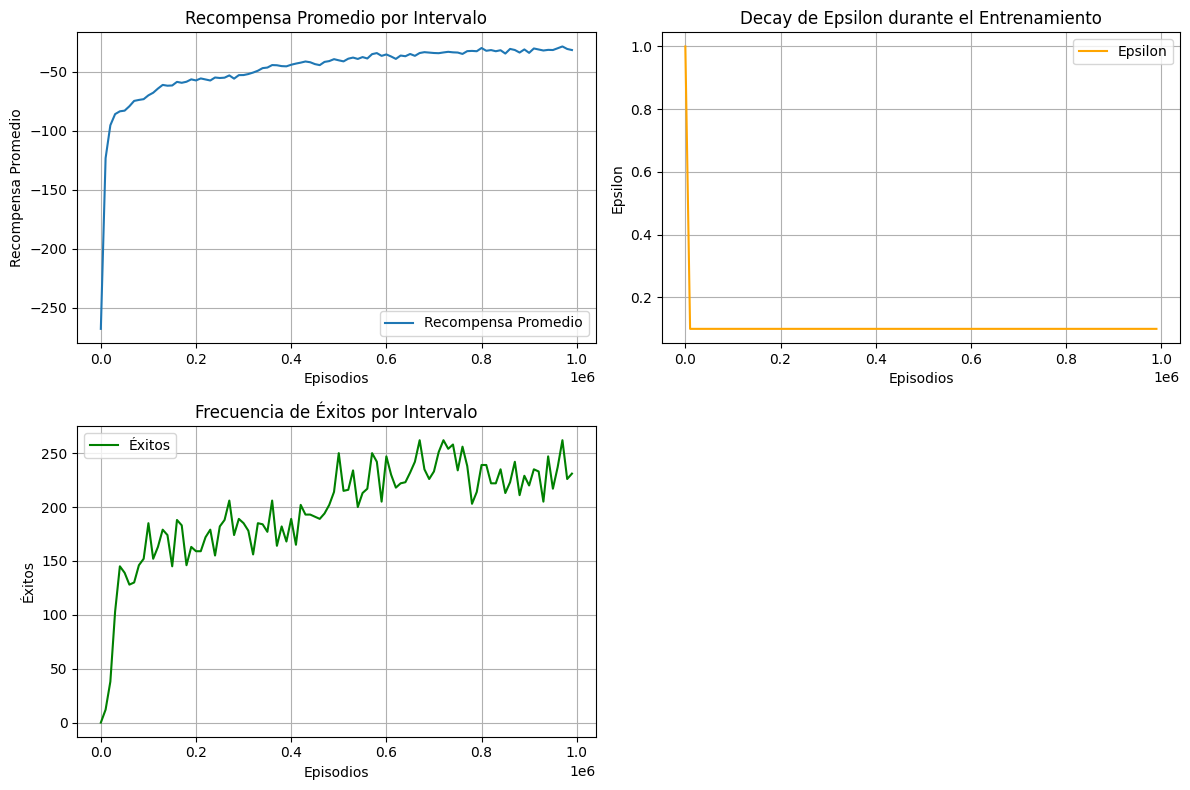

In [7]:
episodios_plot = range(0, episodios, intervalos)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8)) 

# Primera gráfica: Recompensas en función de episodios
plt.subplot(2, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(2, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Tercera gráfica: Éxitos en función de episodios
plt.subplot(2, 2, 3)
plt.plot(episodios_plot, exitos_intervalo_array, label='Éxitos', color='green')
plt.xlabel('Episodios')
plt.ylabel('Éxitos')
plt.title('Frecuencia de Éxitos por Intervalo')
plt.grid(True)
plt.legend()

# Ajustar automáticamente los espacios entre subplots
plt.tight_layout()

# Mostrar las gráficas
plt.show()


A través del gráfico de recompensas promedio cada 10.000 episodios, observamos que inicialmente el agente recibe recompensas negativas bajas, lo que indica un desempeño deficiente en el aterrizaje (choques o aterrizajes ineficientes). Sin embargo, a medida que avanza el entrenamiento, el agente mejora gradualmente su desempeño, llegando a un promedio de recompensa superando los -50. Esto sugiere que el agente está aprendiendo a aterrizar de manera más segura y controlada con el tiempo. Sin embargo, la recompensa promedio sigue siendo negativa, por lo que no estamos teniendo una tasa de éxito ideal.

Luego, en el gráfico de decaimiento del epsilon, como era de esperarse, al ser el factor de decaimiento `decay_factor = 0.9`, el espilon disminuye al mínimo en las primeras 1000 iteraciones, dando mayor énfasis a la explotación sobre la exploración para el resto de episodios. Aún así, con el valor mínimo de epsilon establecido, por cada iteración se mantendrá un 10% de probabilidad de exploración, permitiendo que esto aún ocurra a lo largo del entrenamiento.

Por último, es observable que existe una tendencia a la mejora en la frecuencia de éxitos del agente, indicando que efectivamente está aprendiendo y obteniendo aterrizajes exitosos

In [155]:
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]
    
print(f"Porcentaje de éxitos: {((exitos / num_episodios) * 100):.2f}%. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


Porcentaje de éxitos: 4.20%. Se obtuvo -22.191203517924084 de recompensa, en promedio


Una vez entrenado nuestro agente, ejecutamos episodios donde el agente no aprenderá (parámetro `aprender=False`) para evaluar su desempeño. A través de la ejecución de 1000 episodios de evaluación, obtenemos una tasa de éxito consistentemente mayor a 3%, cumpliendo con el objetivo de la tarea.

## **4. Evaluación**

#### **4.1 Análisis de casos exitosos y fallidos**

El objetivo de esta sección es el de examianr el comportamiento del agente a lo largo de un episodio y encontrar una relación entre las acciones tomadas y la recompensa acumulada. Particularmente, examinaremos episodios exitosos y fallidos para identificar patrones de comportamiento que puedan explicar el éxito o fracaso del agente.

Para la realización de los gráficos que utilizamos, implementamos la función `ejecutar_episodio_graf` que es similar a `ejecutar_episodio` pero que además de ejecutar el episodio, guarda la información necesaria para graficar el comportamiento del agente. Luego, para obtener un caso exitoso y uno fallido, utilizamos la función `episodios_hasta_exito_o_fallo` que simplemente itera hasta encontrar el caso buscado (dependiendo del parámetro booleano `exito`) 

In [129]:
def ejecutar_episodio_graf(agente, aprender, render, max_iteraciones=500):
    recompensa_iter = []
    angulo_iteracion = []
    pata_izq_iter = 0
    pata_der_iter = 0
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        angulo_iteracion.append(estado_anterior[4])
        if ((not pata_izq_iter) and estado_anterior[6]):
            pata_izq_iter = iteraciones
        if ((not pata_der_iter) and estado_anterior[7]):
            pata_der_iter = iteraciones 
        iteraciones += 1
        recompensa_total += recompensa
        recompensa_iter.append(recompensa_total)
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter

In [130]:
# Ejecutamos episodios hasta obtenner un episodio exitoso o fallido, dependiendo del parámetro booleano exito
def episodios_hasta_exito_o_fallo(exito):
    while True:
        recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter = ejecutar_episodio_graf(agente, aprender=False, render=False)
        if (exito and recompensa >= 200) or (not exito and recompensa <= -200):
            return recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter

In [137]:
def plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter):
    episodio_plot = range(0, iteraciones)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot recompensa on the left y-axis
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Recompensa acumulada', color='blue')
    ax1.plot(episodio_plot, recompensa_iter, label='Recompensa acumulada', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Plot angle on the right y-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Ángulo de giro', color='orange')
    ax2.plot(episodio_plot, angulo_iteracion, label='Ángulo de giro', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    axvline_izq = None
    axvline_der = None
    
    if (pata_izq_iter != 0):
        axvline_izq = ax1.axvline(x=pata_izq_iter, color='green', linestyle='--', linewidth=2)
    if (pata_der_iter != 0):
        axvline_der = ax1.axvline(x=pata_der_iter, color='red', linestyle='dashdot', linewidth=2)
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    
    combined_lines = lines_1 + ([axvline_izq] if axvline_izq else []) + ([axvline_der] if axvline_der else [])
    combined_labels = labels_1 + (['Primer contacto de pata izquierda'] if axvline_izq else []) + (['Primer contacto de pata derecha'] if axvline_der else [])
    
    plt.legend(combined_lines, combined_labels, loc='best')
    
    plt.title('Recompensa acumulada y Ángulo de giro por iteración')
    fig.tight_layout()  
    plt.show()

    print('Recompensa: ', recompensa)


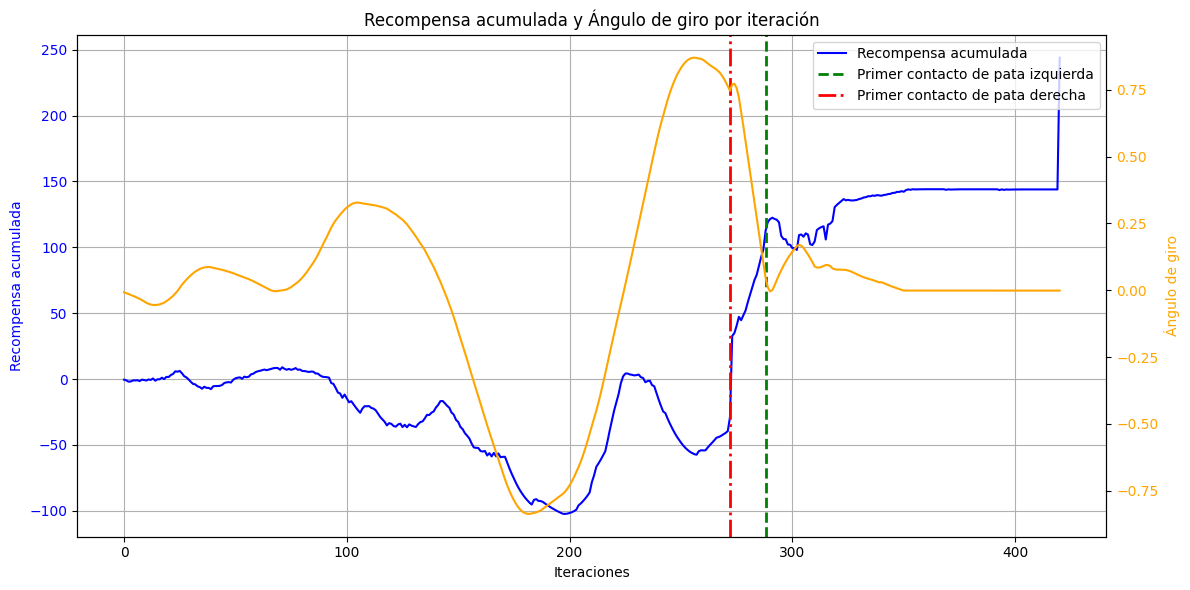

Recompensa:  243.93014891225408


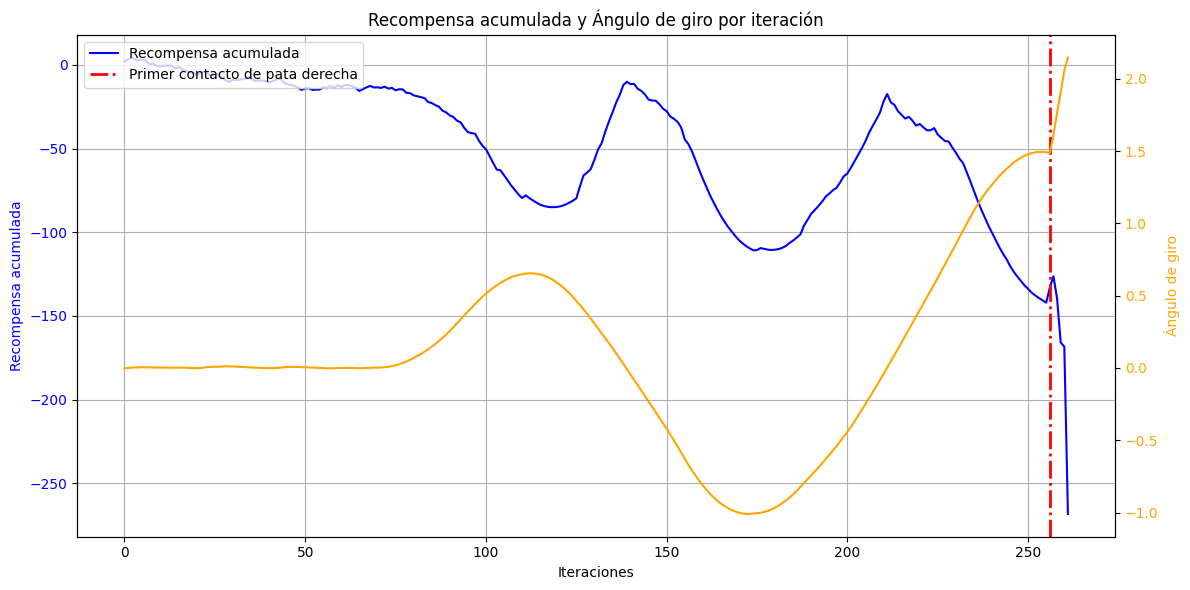

Recompensa:  -268.31433668827015


In [141]:
## Episodio exitoso
recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter = episodios_hasta_exito_o_fallo(True)
plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter)

## Episodio fallido
recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter = episodios_hasta_exito_o_fallo(False)
plot_recompensa_rotacion(recompensa, iteraciones, recompensa_iter, angulo_iteracion, pata_izq_iter, pata_der_iter)

Cabe destacar que para la búsqueda de episodios exitosos y fallidos se ha considerado un caso de falla cuando la recompensa obtenida es menor o igual a -200, y un caso de éxito cuando la recompensa es mayor o igual a 200.

Después de analizar múltiples ejecuciones del agente a lo largo de un episodio, hemos observado que las variaciones repentinas en el ángulo de giro de la nave están relacionadas con una disminución de la recompensa. Específicamente, cuando el ángulo de giro se aleja de 0, la recompensa acumulada tiende a disminuir, lo que refleja una pérdida de control y estabilidad. A medida que el ángulo se aproxima nuevamente a 0, es decir, cuando la nave se endereza, la recompensa acumulada comienza a incrementarse. Este comportamiento se debe a que el giro afecta significativamente la estabilidad de la nave, y en muchos episodios, desviaciones pronunciadas en el ángulo de giro han llevado a aterrizajes fallidos.

Con esto, es posible observar que en la mayoría de los casos en los que el agente falla, el ángulo de giro tiende a alejarse de 0 hacia el final del episodio, por lo que el agente no ha aterrizado con ambas patas en el suelo (posible comprobarlo con lineas añadidas al alcanzar una pata el suelo). El contacto de las patas es otro factor que influye en el ángulo de giro del agente, y esto puede ser visto en varios picos presentes en el gráfico de ángulo de giro.

En cambio, casos exitosos presentan un ángulo de giro estable hacia el final del episodio. Esto no quita que la nave no gire a lo largo del episodio. Es más, hemos observado que el agente tiene como principal método de decenso el rotar en algún sentido y encender el propulsor necesario para enlentecer la caída y enderezarse. Esto lo repite múltiples veces hasta aterrizar. Por esto, en todo caso exitoso, la nave no mantiene un ángulo de giro constante, sino que lo varía controladamente para decender, y lo estabiliza hacia el final.

#### **4.2 Cortes de matriz Q**

La función `state_examples` tiene como objetivo realizar un corte en la matriz Q, extrayendo subconjuntos de valores correspondientes a diferentes combinaciones de estados discretizados que representan situaciones específicas en el entorno del agente. Este corte permite analizar cómo se comporta el agente en esos estados particulares y cómo varían los valores Q para cada acción disponible, o sea, cómo el agente evalúa las acciones en función de la situación en la que se encuentra.

La función recibe varios parámetros que definen los rangos de las características del estado del agente. Dada la división en 20 bins de cada dimensión, cada parámetro tendrá como valor posible un número entero entre 0 y 19 excepto los de contacto de los pies. Los parámetros son:

- **min_x**, **max_x**: Se proporcionan los valores máximo y mínimo de x, donde **x = 0** corresponde al valor mínimo contenido en el bin número 10. Los valores mayores se asignan a bins superiores y los menores a bins inferiores.
- **min_y**, **max_y**: Se incluyen los valores máximo y mínimo de y, siendo **y = 0 a 3** (punto de aterrizaje) el valor mínimo del bin número 1. El valor de inicio en 11
- **theta_izq**, **theta_der**, **theta_vel_izq**, **theta_vel_der**: Se especifican tanto el ángulo máximo como el mínimo, así como las velocidades de rotación máxima y mínima. De manera análoga a las velocidades en los ejes x e y, el valor 0 se asocia al bin 10, con las rotaciones en sentido antihorario asignadas a bins mayores y las rotaciones en sentido horario a bins menores.
- **pie_izq_en_contacto**, **pie_der_en_contacto**: Indican si los pies izquierdo o derecho del agente están en contacto con el suelo. 

Dentro de la función, se generan múltiples combinaciones de estos parámetros, que se utilizan para obtener el índice correspondiente en la matriz Q. De estos valores, se descartan todos los estados que nunca hayan sido visitados. Estos índices se calculan con la función `agente.estado_discretizado_a_indice`, detallada previamente en el informe.

Con el propósito de poder analizar el conjunto de datos, se utilizan promedios de recompensa asociados a cada acción de todas las filas extraídas de Q para entender las tendencias en estados similares.


In [13]:
def state_examples(min_x, max_x, min_y, max_y, delta_x_vel, delta_y_vel, theta_izq, theta_der, theta_vel_izq, theta_vel_der, pie_izq_en_contacto, pie_der_en_contacto):
    Rows = []
    for x in range(min_x,max_x):
        for y in range(min_y,max_y):
            for x_vel in range(9-delta_x_vel,11+delta_x_vel):
                for y_vel in range(9-delta_y_vel,11+delta_y_vel):
                    for theta in range(9-theta_der,11+theta_izq):
                        for theta_vel in range(9-theta_vel_der,11+theta_vel_izq):
                            index = (int) (agente.estado_discretizado_a_indice([x,y,x_vel,y_vel,theta,theta_vel,pie_izq_en_contacto,pie_der_en_contacto]))
                            Rows = np.append(Rows, index)
    mRows = np.zeros(((int) (len(Rows)),4))
    for i in range(len(Rows)):
        mRows[i] = agente.Q[(int) (Rows[i])]
    mRows = mRows[np.any(mRows != 0, axis=1)]
    return mRows

Como ejemplo para ilustrar el funcionamiento, se presenta un corte completo de los casos en los que la nave se encuentra centrada en la posición de inicio, sin velocidad ni rotación. Dada una fila, se prefiere aquella acción con mayor recompensa.

In [14]:
print('Ejemplo')
ejemplo = state_examples(min_x=9, max_x=10, min_y=11, max_y=12, delta_x_vel=0, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print('Cantidad de estados: ',len(ejemplo))
print(ejemplo)
print('Promedio: ',np.mean(ejemplo, 0))

Ejemplo
Cantidad de estados:  16
[[ 4.43451392  7.51392765  7.97733527  4.41753803]
 [14.62600281 13.40877127 15.60148703  8.95987944]
 [18.42569641 16.19193542 20.08862207 18.85693639]
 [ 8.2577984   6.86015242  9.92917925 11.64454216]
 [ 6.83285581 10.58884639  9.19451379  6.50902514]
 [15.75256376 14.42478304 14.77470693 10.68237604]
 [18.53464916 13.41958471 15.74071253 17.84342271]
 [10.10120626  9.24268278 11.35925218 13.58019564]
 [ 5.07190955  9.03152852  3.3631386   3.63011867]
 [18.59508248 17.69361619 19.34538458 14.86575161]
 [16.65092803  9.27718764 17.37090987 15.38573965]
 [ 0.62975841 -0.56460009  4.64386632  3.02338178]
 [ 6.00802357 11.72254747  8.04026679  5.88471533]
 [19.90180371 19.90117489 17.75373974 15.34191535]
 [16.81485684  7.9458991  14.75283239 14.30263468]
 [ 4.15679516  3.80233261  7.46133613  9.24433911]]
Promedio:  [11.54965277 10.65377313 12.33733022 10.88578198]


Luego, con esta función definida, se realizan varios cortes en la matriz Q que, mediante variaciones de los parámetros previamente descritos, describen posibles situaciones en las que podría estar nuestro agente. Luego, obtenemos para cada una de las acciones, obtenemos en cuantas de estas situaciones eligió esa acción.

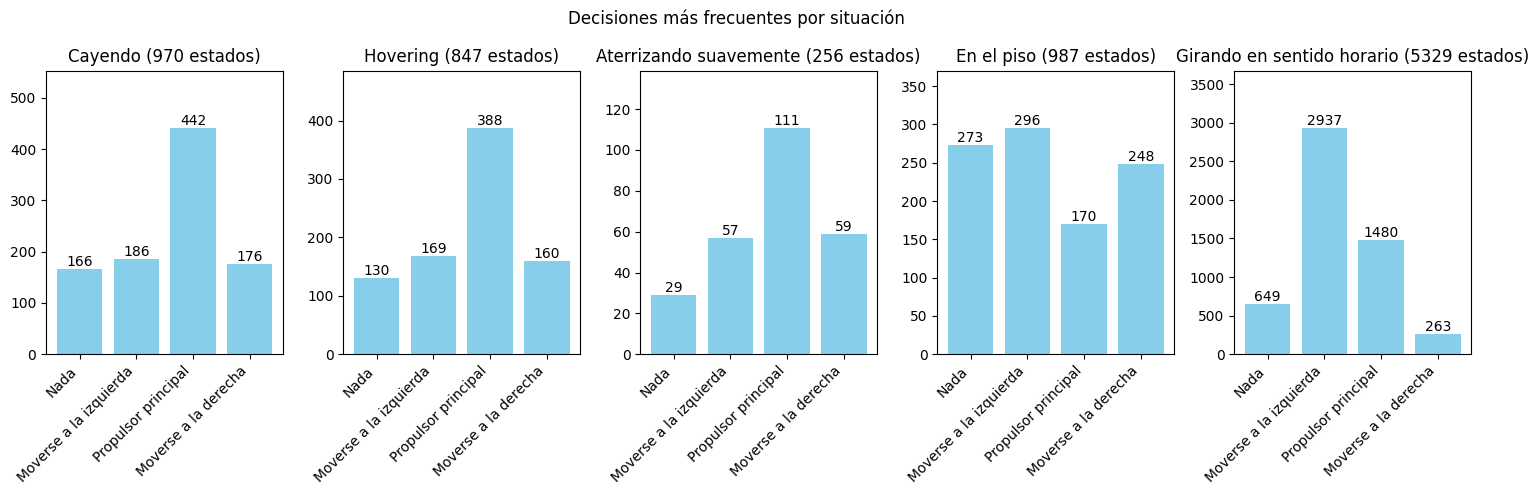

In [180]:
def contar_maximos_por_accion(Q_slice):
    contador_maximos = np.array([0,0,0,0])
    
    for fila in Q_slice:
        accion_maxima = np.argmax(fila)
        contador_maximos[accion_maxima] += 1
    return contador_maximos

# Cayendo
falling = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=3, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
falling_decisions = contar_maximos_por_accion(falling)

# Hovering
hovering = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=1, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
hovering_decisions = contar_maximos_por_accion(hovering)

# Aterrizando suavemente
landing_soft = state_examples(min_x=8, max_x=12, min_y=0, max_y=4, delta_x_vel=0, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
landing_soft_decisions = contar_maximos_por_accion(landing_soft)

# En el piso
floor = state_examples(min_x=0, max_x=20, min_y=0, max_y=9, delta_x_vel=1, delta_y_vel=0, theta_izq=0, theta_der=0, theta_vel_izq=0, theta_vel_der=0, pie_izq_en_contacto=1, pie_der_en_contacto=1)
floor_decisions = contar_maximos_por_accion(floor)

# Girado en sentido horario en el aire
falling_spinning = state_examples(min_x=4, max_x=16, min_y=4, max_y=12, delta_x_vel=1, delta_y_vel=1, theta_izq=-2, theta_der=3, theta_vel_izq=0, theta_vel_der=3, pie_izq_en_contacto=0, pie_der_en_contacto=0)
falling_spinning_decisions = contar_maximos_por_accion(falling_spinning)

states_decisions = [falling_decisions, hovering_decisions, landing_soft_decisions, floor_decisions, falling_spinning_decisions]
states = {
    'Cayendo': falling_decisions,
    'Hovering': hovering_decisions,
    'Aterrizando suavemente': landing_soft_decisions,
    'En el piso': floor_decisions,
    'Girando en sentido horario': falling_spinning_decisions
}
states_lengths = {
    'Cayendo': len(falling),
    'Hovering': len(hovering),
    'Aterrizando suavemente': len(landing_soft),
    'En el piso': len(floor),
    'Girando en sentido horario': len(falling_spinning)
}

fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=False)

actions = ['Nada', 'Moverse a la izquierda', 'Propulsor principal', 'Moverse a la derecha']
x_positions = range(len(actions))

# Loop over the states and create a histogram for each
for i, (state, decisions) in enumerate(states.items()):
    axs[i].bar(actions, decisions, color='skyblue')
    for j, value in enumerate(decisions):
        axs[i].text(j, value, f'{value}', ha='center', va='bottom')
    axs[i].set_xticks(x_positions)
    axs[i].set_xticklabels(actions, rotation=45, ha='right')
    axs[i].set_title(f'{state} ({states_lengths[state]} estados)')
    axs[i].set_ylim(0, decisions.max() + decisions.max()*0.25)

fig.suptitle('Decisiones más frecuentes por situación')
plt.tight_layout()
plt.show()


- En el primer caso, cuando la nave está cayendo con poca rotación, se observa que la acción más común es prender el propulsor principal, con un total de 442 estados. Esto tiene sentido ya que la activación del propulsor principal reduce la velocidad vertical de la nave.

- De manera análoga, cuando la nave presenta poca velocidad vertical, escasa rotación y se encuentra centrada horizontalmente en el aire, la política indica que debe activarse el propulsor principal. Creemos que esta estrategia es lo que lleva a la nave a flotar estáticamente que hemos notado al ejecutar episodios.

- En el caso de aterrizaje suave, la acción más frecuente sigue siendo prender el propulsor principal, lo que es natural en la etapa de aterrizaje, ya que la nave debe reducir la velocidad vertical para aterrizar correctamente. No tomar acciones es relativamente poco frecuente en este caso, lo que indica que el agente está activamente intentando aterrizar la nave de manera controlada.

- En el penúltimo caso, cuando la nave está en contacto con el suelo, podemos destacar que la acción menos frecuentemente elegida es la de encender el propulsor principal, indicando que el agente ha aprendido que una vez en contacto con el suelo, no es necesario activarlo.

- Finalmente, cuando la nave está girando hacia la derecha en el aire con una gran velocidad de rotación, la acción más frecuente es moverse hacia la izquierda, lo que corresponde a activar el propulsor derecho para contrarrestar el giro. Esto tiene sentido dado que el objetivo del agente es reducir la velocidad de rotación.


## **5. Limitantes del agente RL**
La discretización del espacio de estados puede ser una limitante importante en el rendimiento de un agente de aprendizaje por refuerzo porque implica una pérdida de precisión. Al transformar variables continuas en intervalos discretos, se agrupan múltiples valores en un mismo estado, lo que puede hacer que el agente pierda información crucial para tomar decisiones finas. Esto puede afectar en esta realidad porque una leve variación en el ángulo de giro por ejemplo, puede llevar a un aterrizaje exitoso o fallido, y esta variación a la hora de la discretización puede no ser correctamente representada.

Además, el esquema de epsilon decay implementado permite reducir gradualmente la probabilidad de que el agente explore acciones aleatorias (exploración) a medida que aprende. Sin embargo, el decay puede ser una limitante si se reduce demasiado rápido, ya que puede ocurrir que el agente deje de explorar antes de haber cubierto suficiente espacio de estados, lo que lo llevará a aprender y continuamente utilizar políticas subóptimas.